In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


In [2]:
import logging
import os
import random
from collections import Counter
from importlib import reload
import time

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [3]:
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()  # For easy reset of notebook state.

## load in data

In [4]:
expression_fp = '/data/stemness/ERP016000/counts.tsv'
metadata_fp = '/data/stemness/ERP016000/cell_metadata_cols.tsv'

In [6]:
# expression_df = pd.read_csv(expression_fp, sep='\t')
# expression_df
expression_df = pd.read_hd5(expression_fp.replace('.tsv', '.hd5'), 'df')

,21843_1#10,21843_1#100,21843_1#101,21843_1#102,21843_1#103,21843_1#105,21843_1#106,21843_1#107,21843_1#108,21843_1#109,...,24539_8#88,24539_8#89,24539_8#90,24539_8#91,24539_8#92,24539_8#93,24539_8#94,24539_8#95,24539_8#97,24539_8#98
ENSG00000000003_TSPAN6,5.520777,6.456208,5.878671,4.860824,5.903640,4.513537,6.401983,5.909216,5.366645,3.228852,...,5.841814,6.104105,6.275649,7.029407,5.806978,6.199875,7.014180,6.228476,6.217161,6.034232
ENSG00000000419_DPM1,5.392461,6.065923,6.838769,6.614268,6.512403,5.527439,6.525591,6.381135,6.157296,6.248478,...,6.543807,6.369119,7.185421,6.337047,6.162437,5.885993,7.431358,7.013124,4.851771,4.937248
ENSG00000000457_SCYL3,0.000174,0.352597,0.000000,0.825955,2.201697,0.262446,0.000000,1.506837,0.283516,3.241977,...,0.017386,0.949668,0.035526,0.032044,1.773369,0.000000,0.108025,1.756339,2.492943,1.363441
ENSG00000000460_C1orf112,1.471928,4.536968,4.318528,5.373009,4.636175,4.225468,0.409785,3.668277,3.057933,3.154891,...,4.720967,3.791536,2.696476,4.227515,4.243689,3.227508,2.621121,3.950978,3.926914,4.211904
ENSG00000001036_FUCA2,2.908802,3.867327,3.321747,3.736476,4.917576,2.456866,0.577839,4.777404,2.873857,2.536708,...,3.070608,4.491643,4.206249,3.695005,2.652845,4.221847,3.188030,4.741496,3.872743,4.374577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000271043_MTRNR2L2,8.993125,10.310311,10.112632,9.380978,9.511378,7.531314,9.565223,9.659486,7.748536,10.087547,...,5.273407,5.649628,5.465876,5.388675,5.636233,1.709041,7.568684,6.345048,7.577899,7.012576
ENSG00000271303_SRXN1,0.000000,0.000000,0.390075,0.000000,0.000000,0.000000,0.000000,0.000000,2.388986,0.000000,...,0.000000,3.061808,1.707139,0.000000,2.637493,0.000000,0.000000,0.284224,0.000000,0.000000
ENSG00000272047_GTF2H5,1.397666,1.399811,2.421133,2.250520,2.633359,2.078498,1.513069,2.972922,2.012249,1.675936,...,2.316120,2.299498,2.392277,1.653269,2.254969,3.208027,4.137374,1.847985,2.144427,2.105545
ENSG00000272325_NUDT3,0.716015,1.857059,2.499615,2.615108,1.682406,2.295494,2.040256,1.896238,1.236113,1.544098,...,1.210306,0.538546,1.002614,1.901335,1.037860,2.139444,0.852408,1.091890,2.796956,2.493385


In [8]:
# expression_df.to_hdf(expression_fp.replace('.tsv', '.hd5'), 'df')

In [9]:
expression_df.index = [c.split('_')[-1] for c in expression_df.index]
expression_df

,21843_1#10,21843_1#100,21843_1#101,21843_1#102,21843_1#103,21843_1#105,21843_1#106,21843_1#107,21843_1#108,21843_1#109,...,24539_8#88,24539_8#89,24539_8#90,24539_8#91,24539_8#92,24539_8#93,24539_8#94,24539_8#95,24539_8#97,24539_8#98
TSPAN6,5.520777,6.456208,5.878671,4.860824,5.903640,4.513537,6.401983,5.909216,5.366645,3.228852,...,5.841814,6.104105,6.275649,7.029407,5.806978,6.199875,7.014180,6.228476,6.217161,6.034232
DPM1,5.392461,6.065923,6.838769,6.614268,6.512403,5.527439,6.525591,6.381135,6.157296,6.248478,...,6.543807,6.369119,7.185421,6.337047,6.162437,5.885993,7.431358,7.013124,4.851771,4.937248
SCYL3,0.000174,0.352597,0.000000,0.825955,2.201697,0.262446,0.000000,1.506837,0.283516,3.241977,...,0.017386,0.949668,0.035526,0.032044,1.773369,0.000000,0.108025,1.756339,2.492943,1.363441
C1orf112,1.471928,4.536968,4.318528,5.373009,4.636175,4.225468,0.409785,3.668277,3.057933,3.154891,...,4.720967,3.791536,2.696476,4.227515,4.243689,3.227508,2.621121,3.950978,3.926914,4.211904
FUCA2,2.908802,3.867327,3.321747,3.736476,4.917576,2.456866,0.577839,4.777404,2.873857,2.536708,...,3.070608,4.491643,4.206249,3.695005,2.652845,4.221847,3.188030,4.741496,3.872743,4.374577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MTRNR2L2,8.993125,10.310311,10.112632,9.380978,9.511378,7.531314,9.565223,9.659486,7.748536,10.087547,...,5.273407,5.649628,5.465876,5.388675,5.636233,1.709041,7.568684,6.345048,7.577899,7.012576
SRXN1,0.000000,0.000000,0.390075,0.000000,0.000000,0.000000,0.000000,0.000000,2.388986,0.000000,...,0.000000,3.061808,1.707139,0.000000,2.637493,0.000000,0.000000,0.284224,0.000000,0.000000
GTF2H5,1.397666,1.399811,2.421133,2.250520,2.633359,2.078498,1.513069,2.972922,2.012249,1.675936,...,2.316120,2.299498,2.392277,1.653269,2.254969,3.208027,4.137374,1.847985,2.144427,2.105545
NUDT3,0.716015,1.857059,2.499615,2.615108,1.682406,2.295494,2.040256,1.896238,1.236113,1.544098,...,1.210306,0.538546,1.002614,1.901335,1.037860,2.139444,0.852408,1.091890,2.796956,2.493385


In [10]:
expression_df = expression_df.transpose()
expression_df

,TSPAN6,DPM1,SCYL3,C1orf112,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,...,LUC7L2,ZNF559-ZNF177,HSPE1-MOB4,RPS10-NUDT3,SRGAP2D,MTRNR2L2,SRXN1,GTF2H5,NUDT3,CD24
21843_1#10,5.520777,5.392461,0.000174,1.471928,2.908802,0.127185,0.000000,3.615650,0.000000,5.604953,...,0.575989,0.290480,3.342019,2.955039,0.286690,8.993125,0.000000,1.397666,0.716015,2.578313
21843_1#100,6.456208,6.065923,0.352597,4.536968,3.867327,0.047614,4.277551,0.000000,0.000000,5.848853,...,1.379352,0.000000,2.642681,0.315327,0.446590,10.310311,0.000000,1.399811,1.857059,0.000000
21843_1#101,5.878671,6.838769,0.000000,4.318528,3.321747,4.042388,0.000000,2.545334,0.185345,5.196831,...,3.051514,0.000000,3.053322,1.082602,0.000000,10.112632,0.390075,2.421133,2.499615,0.889010
21843_1#102,4.860824,6.614268,0.825955,5.373009,3.736476,2.662104,1.115943,0.000000,0.000000,3.811312,...,2.453614,0.000000,2.503949,2.271033,0.000000,9.380978,0.000000,2.250520,2.615108,1.963302
21843_1#103,5.903640,6.512403,2.201697,4.636175,4.917576,2.499359,2.278948,2.672572,0.243054,4.964217,...,1.613052,0.000000,2.471723,0.218927,0.000000,9.511378,0.000000,2.633359,1.682406,1.412966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24539_8#93,6.199875,5.885993,0.000000,3.227508,4.221847,0.000000,4.137042,1.758011,0.000000,5.039266,...,1.130735,1.937917,1.906042,1.143744,0.000000,1.709041,0.000000,3.208027,2.139444,7.552773
24539_8#94,7.014180,7.431358,0.108025,2.621121,3.188030,1.393474,3.378998,3.703450,0.139112,4.209373,...,0.403450,1.756385,5.584232,1.768525,0.410279,7.568684,0.000000,4.137374,0.852408,7.631217
24539_8#95,6.228476,7.013124,1.756339,3.950978,4.741496,2.465067,3.069041,2.829073,4.306653,5.019318,...,0.474118,0.279475,5.136851,0.203189,1.306076,6.345048,0.284224,1.847985,1.091890,7.109529
24539_8#97,6.217161,4.851771,2.492943,3.926914,3.872743,3.189254,2.178870,1.834021,0.000000,4.075990,...,1.440802,2.394519,3.511525,1.622543,0.000000,7.577899,0.000000,2.144427,2.796956,7.185068


In [31]:
metadata_df = pd.read_csv(metadata_fp, sep='\t')
metadata_df = metadata_df.loc[expression_df.index]
metadata_df = metadata_df[['assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment',
                          'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type']]
metadata_df

,assigned,cell_name,day,donor_long_id,donor_short_id,experiment,total_counts,total_counts_MT,pseudo,sample_id,well_id,well_type
21843_1#10,1,21843_1#10,day1,HPSI0114i-joxm_1,joxm_1,expt_09,598658.209173,45560.066753,0.292682,21843_1#10,A10,single cell
21843_1#100,1,21843_1#100,day1,HPSI0314i-fafq_1,fafq_1,expt_09,222558.809077,26617.964539,0.484716,21843_1#100,E04,single cell
21843_1#101,1,21843_1#101,day1,HPSI0314i-fafq_1,fafq_1,expt_09,582661.572985,55173.613380,0.403809,21843_1#101,E05,single cell
21843_1#102,1,21843_1#102,day1,HPSI1013i-wuye_2,wuye_2,expt_09,476557.701340,37076.110494,0.260772,21843_1#102,E06,single cell
21843_1#103,1,21843_1#103,day1,HPSI0114i-joxm_1,joxm_1,expt_09,404342.711311,28949.266469,0.355366,21843_1#103,E07,single cell
...,...,...,...,...,...,...,...,...,...,...,...,...
24539_8#93,1,24539_8#93,day1,HPSI0713i-nocf_2,nocf_2,expt_35,347580.461936,31633.724898,0.199677,24539_8#93,D21,single cell
24539_8#94,1,24539_8#94,day1,HPSI1013i-zagm_1,zagm_1,expt_35,395735.359197,56999.061471,0.251769,24539_8#94,D22,single cell
24539_8#95,1,24539_8#95,day1,HPSI0314i-wigw_2,wigw_2,expt_35,474715.299368,37026.549761,0.226935,24539_8#95,D23,single cell
24539_8#97,1,24539_8#97,day1,HPSI1113i-wahn_1,wahn_1,expt_35,75472.999850,4251.880902,0.389748,24539_8#97,E01,single cell


In [33]:
adata = anndata.AnnData(X=expression_df.values, obs=metadata_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

AnnData object with n_obs × n_vars = 36044 × 11231 
    obs: 'assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type'

## analysis

this dataset has already been cpm normalized and logged

In [34]:
# # sc.pp.filter_cells(adata, min_genes=200)
# # sc.pp.filter_genes(adata, min_cells=3)
# mito_genes = adata.var_names.str.startswith('MT-')
# # for each cell compute fraction of counts in mito genes vs. all genes
# # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# adata.obs['percent_mito'] = np.sum(
#     adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# # add the total counts per cell as observations-annotation to adata
# adata.obs['n_counts'] = adata.X.sum(axis=1)

# sc.pl.scatter(adata, x='n_counts', y='percent_mito')
# sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [35]:
adata.raw = adata

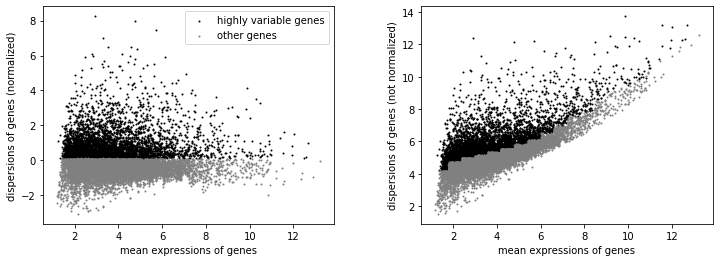

In [45]:
sc.pp.highly_variable_genes(adata, min_mean=0.0, max_mean=15., min_disp=0.1)
sc.pl.highly_variable_genes(adata)

In [46]:
np.count_nonzero(adata.var.highly_variable)

4134

In [47]:
adata.var[adata.var.index=='GATA6']

,highly_variable,means,dispersions,dispersions_norm
GATA6,True,5.886982,7.59323,1.881097


In [48]:
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=None)
adata

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:909: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 36044 × 4134 
    obs: 'assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [49]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(p

In [50]:
n = 5000

idxs = np.arange(adata.shape[0])
np.random.shuffle(idxs)

train_idxs = idxs[:n]
val_idxs = idxs[n:]

train_idxs.shape, val_idxs.shape

((5000,), (31044,))

In [51]:
train_adata = adata[train_idxs, :].copy()
val_adata = adata[val_idxs, :].copy()

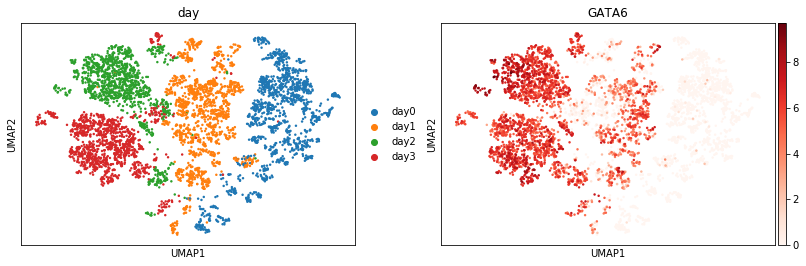

In [53]:
sc.pl.umap(train_adata, color=['day', 'GATA6'], color_map='Reds')

In [55]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
X_train = np.copy(train_adata.X)
X_val = np.copy(val_adata.X)

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train.shape, X_val.shape

((5000, 4134), (31044, 4134))

In [56]:
TRAIN_BUF = 10000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(BATCH_SIZE)

In [61]:
class BVAE(tf.keras.Model):
  def __init__(self, latent_dim, input_size):
    super(BVAE, self).__init__()
    self.latent_dim = latent_dim
    self.input_size = input_size
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(input_size,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(input_size),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [62]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x, alpha=0.00005):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  kl_loss = .5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mean) - 1. - logvar, axis=1)
  reconstruction_loss = .5 * tf.reduce_sum(tf.square((x - x_logit)), axis=1)

  overall_loss = tf.reduce_mean(reconstruction_loss + alpha * kl_loss)
  return overall_loss

@tf.function
def compute_apply_gradients(model, x, optimizer, alpha=.00005):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, alpha=alpha)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [63]:
epochs = 100
latent_dim = 100
alpha = 0.1

model = BVAE(latent_dim, X_train.shape[1])

In [64]:
# generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer, alpha=alpha)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x, alpha=alpha))

    print(f'epoch: {epoch}, val loss: {compute_loss(model, next(iter(test_dataset)), alpha)}')

epoch: 1, val loss: 92.37837219238281
epoch: 2, val loss: 87.08091735839844
epoch: 3, val loss: 83.36319732666016
epoch: 4, val loss: 82.0596923828125
epoch: 5, val loss: 81.62481689453125
epoch: 6, val loss: 79.9874496459961
epoch: 7, val loss: 79.78533172607422
epoch: 8, val loss: 79.23704528808594
epoch: 9, val loss: 78.46794128417969
epoch: 10, val loss: 77.97055053710938
epoch: 11, val loss: 77.4893569946289
epoch: 12, val loss: 77.01880645751953
epoch: 13, val loss: 76.31236267089844
epoch: 14, val loss: 76.54039001464844
epoch: 15, val loss: 75.8145751953125
epoch: 16, val loss: 75.46875762939453
epoch: 17, val loss: 75.4107666015625
epoch: 18, val loss: 74.73219299316406
epoch: 19, val loss: 74.51753234863281
epoch: 20, val loss: 74.21839141845703
epoch: 21, val loss: 74.08042907714844
epoch: 22, val loss: 74.26020812988281
epoch: 23, val loss: 73.77254486083984
epoch: 24, val loss: 73.40812683105469
epoch: 25, val loss: 73.27078247070312
epoch: 26, val loss: 73.05558013916016


In [65]:
mean, logvar = model.encode(train_adata.X)
train_embeddings = model.reparameterize(mean, logvar).numpy()

mean, logvar = model.encode(val_adata.X)
val_embeddings = model.reparameterize(mean, logvar).numpy()

In [66]:
mean, logvar = model.encode(adata.X)
cell_embeddings = model.reparameterize(mean, logvar).numpy()
cell_embeddings

array([[-6.5213275e-01, -9.0257943e-01,  4.1786098e-01, ...,
        -6.7934666e+00,  7.2924793e-01,  9.3674481e-02],
       [ 2.1802590e+00,  1.8999889e-01,  3.2947901e-01, ...,
        -8.3306246e+00,  1.7058041e+00,  3.6901253e-01],
       [ 1.5012149e+00, -7.3092663e-01,  1.2622359e-01, ...,
        -7.3673849e+00,  8.1967491e-01, -1.2318729e+00],
       ...,
       [ 1.4708407e+00, -1.8610992e+00,  8.1962645e-03, ...,
        -3.3385258e+00,  1.0313913e+00, -1.2064731e+00],
       [ 1.5389315e+00, -1.1180952e+00, -1.2905997e-01, ...,
        -5.5407553e+00,  7.7274978e-01, -1.3548280e+00],
       [-2.9417794e+00, -3.1268954e-01, -3.1198773e-01, ...,
        -3.3260634e+00,  2.4331242e-01, -3.9458528e-01]], dtype=float32)

In [67]:
adata.obsm['cell_embeddings'] = cell_embeddings
adata

AnnData object with n_obs × n_vars = 36044 × 4134 
    obs: 'assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'cell_embeddings'
    varm: 'PCs'

In [68]:
import umap
adata.obsm['cell_embedding_umap'] = umap.UMAP().fit_transform(adata.obsm['cell_embeddings'])
adata

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/nndescent.py", line 47:
    @

AnnData object with n_obs × n_vars = 36044 × 4134 
    obs: 'assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'cell_embeddings', 'cell_embedding_umap'
    varm: 'PCs'

Trying to set attribute `.obs` of view, copying.
... storing 'day' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor_long_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor_short_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'experiment' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'well_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'well_type' as categorical


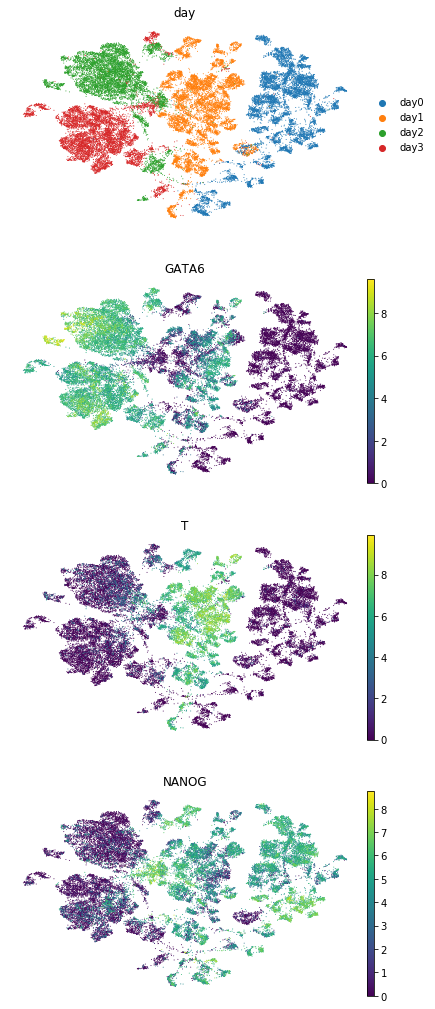

In [75]:
sc.pl.umap(adata[val_idxs], color=['day', 'GATA6', 'T', 'NANOG'], frameon=False, ncols=1, )

In [70]:
adata.obs['cell_embedding_umap1'] = adata.obsm['cell_embedding_umap'][:, 0]
adata.obs['cell_embedding_umap2'] = adata.obsm['cell_embedding_umap'][:, 1]

Trying to set attribute `.obs` of view, copying.
... storing 'day' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor_long_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor_short_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'experiment' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'well_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'well_type' as categorical


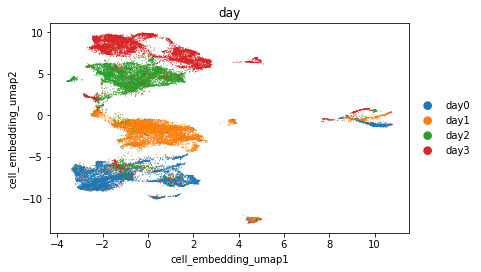

Trying to set attribute `.obs` of view, copying.
... storing 'day' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor_long_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor_short_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'experiment' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'well_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'well_type' as categorical


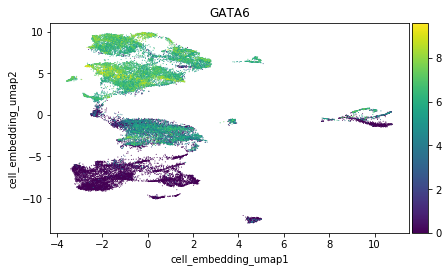

Trying to set attribute `.obs` of view, copying.
... storing 'day' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor_long_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor_short_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'experiment' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'well_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'well_type' as categorical


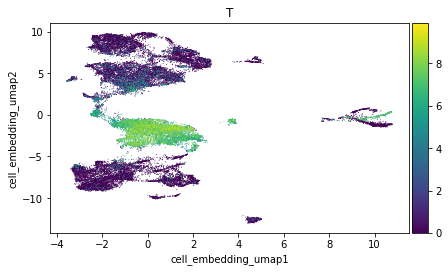

Trying to set attribute `.obs` of view, copying.
... storing 'day' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor_long_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'donor_short_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'experiment' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'well_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'well_type' as categorical


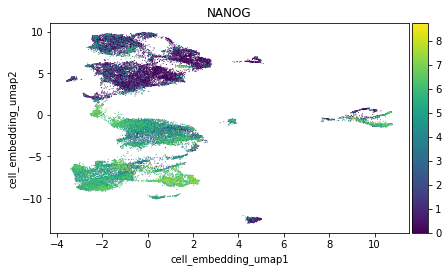

In [72]:
variables = ['day', 'GATA6', 'T', 'NANOG']
for var in variables:
    sc.pl.scatter(adata[val_idxs], x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                 frameon=False)
    plt.show()

In [76]:
adata.obs['donor_short_id']

21843_1#10     joxm_1
21843_1#100    fafq_1
21843_1#101    fafq_1
21843_1#102    wuye_2
21843_1#103    joxm_1
                ...  
24539_8#93     nocf_2
24539_8#94     zagm_1
24539_8#95     wigw_2
24539_8#97     wahn_1
24539_8#98     wahn_1
Name: donor_short_id, Length: 36044, dtype: object

In [78]:
filtered = adata[adata.obs['donor_short_id']=='joxm_1'].copy()
filtered

AnnData object with n_obs × n_vars = 1415 × 4134 
    obs: 'assigned', 'cell_name', 'day', 'donor_long_id', 'donor_short_id', 'experiment', 'total_counts', 'total_counts_MT', 'pseudo', 'sample_id', 'well_id', 'well_type', 'cell_embedding_umap1', 'cell_embedding_umap2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'cell_embeddings', 'cell_embedding_umap'
    varm: 'PCs'

... storing 'day' as categorical
... storing 'donor_long_id' as categorical
... storing 'donor_short_id' as categorical
... storing 'experiment' as categorical
... storing 'well_id' as categorical
... storing 'well_type' as categorical


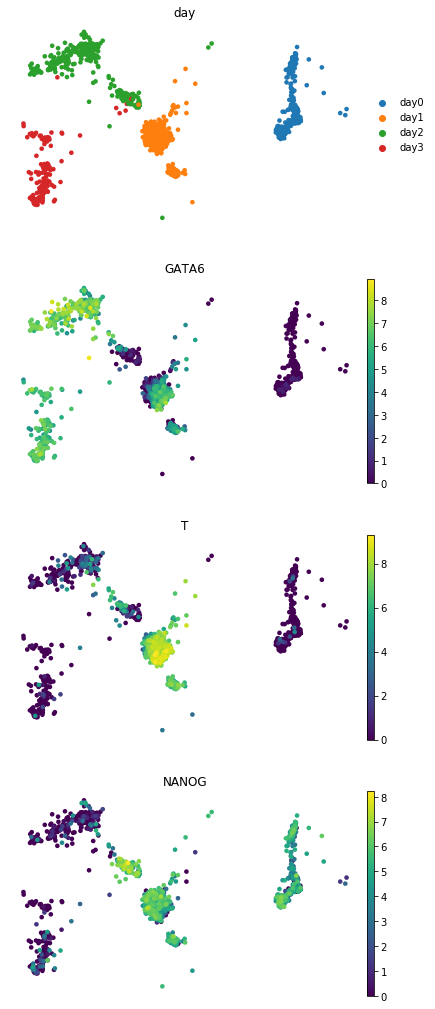

In [80]:
sc.pl.umap(filtered, color=['day', 'GATA6', 'T', 'NANOG'], frameon=False, ncols=1, )

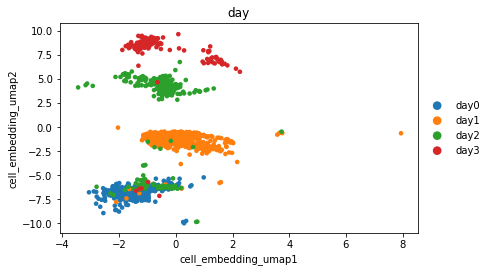

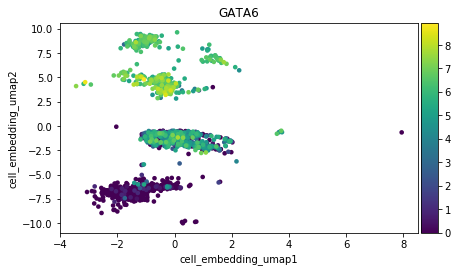

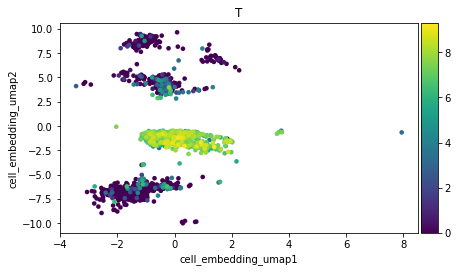

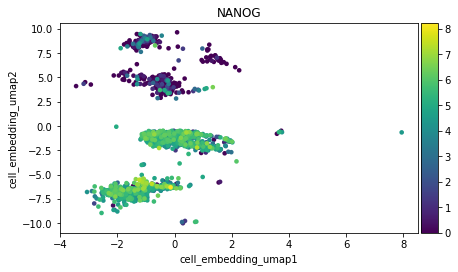

In [81]:
variables = ['day', 'GATA6', 'T', 'NANOG']
for var in variables:
    sc.pl.scatter(filtered, x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                 frameon=False)
    plt.show()

In [83]:
adata.obsm['cell_embeddings'].shape

(36044, 100)

In [96]:
gene = 'SOX2'
idx = list(filtered.var.index).index(gene)
gene, idx

('SOX2', 3248)

In [97]:
import scipy

In [99]:
tups = []
for i in range(filtered.obsm['cell_embeddings'].shape[1]):
    position_vals = filtered.obsm['cell_embeddings'][:, i].flatten()
    correlation = scipy.stats.pearsonr(position_vals, filtered[:, gene].X.flatten())
    r = correlation[0]
    tups.append((i, r))
    
    filtered.obs[f'position_{i}'] = position_vals
tups = sorted(tups, key=lambda x: x[1])
tups[:10], tups[-10:]

([(77, -0.4606477315573578),
  (65, -0.3746509058477754),
  (75, -0.34387104607395463),
  (73, -0.33377318805759126),
  (16, -0.2940861344767694),
  (91, -0.2857884274231111),
  (25, -0.2715071489317917),
  (84, -0.2593383447895874),
  (38, -0.23124105023473668),
  (85, -0.22289147901894718)],
 [(72, 0.23517344851721259),
  (41, 0.23825205038649946),
  (14, 0.2467733043773644),
  (71, 0.26667747948372705),
  (96, 0.26712405790778765),
  (81, 0.2930876786840373),
  (90, 0.30776318423416726),
  (32, 0.35210012417507414),
  (62, 0.48199891528226313),
  (13, 0.6825666407438252)])

In [ ]:
spot = 13

filtered.obs['spot_13']

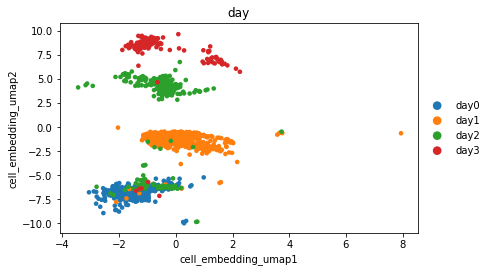

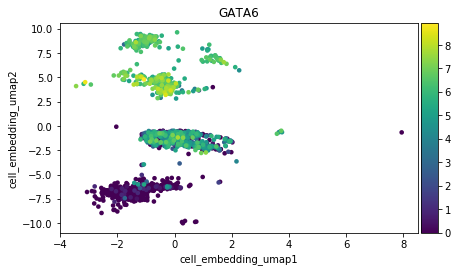

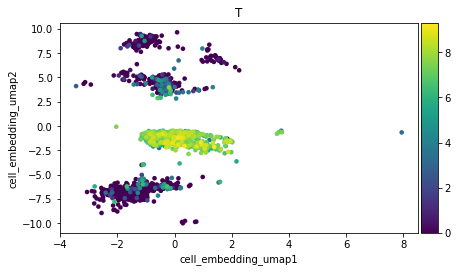

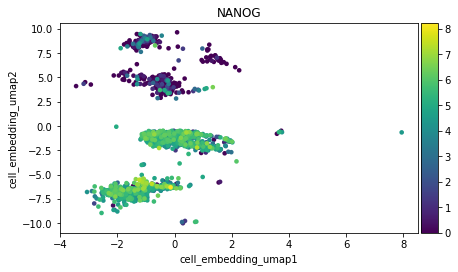

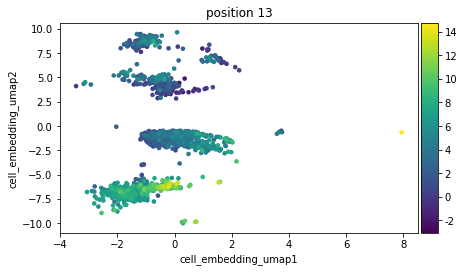

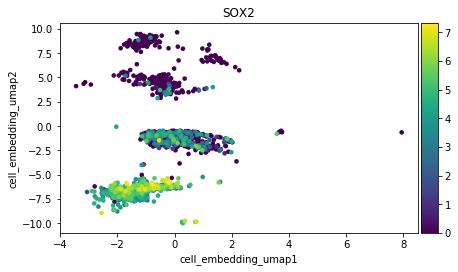

In [95]:
variables = ['day', 'GATA6', 'T', 'NANOG', 'position_13', 'SOX2']
for var in variables:
    sc.pl.scatter(filtered, x='cell_embedding_umap1', y='cell_embedding_umap2', color=var,
                 frameon=False)
    plt.show()

In [94]:
[x for x in adata.var.index if 'SOX' in x]

['SOX6', 'SOX4', 'SOX15', 'SOX5', 'SOX17', 'SOX11', 'SOX12', 'SOX2', 'SOX18']